# LibEMG MEC24 Walkthrough

This notebook was created to provide a quick, interactive walkthrough of some of the key components in `LibEMG`. We step through the process of loading in data, filtering, feature extraction, and model fitting.

In [166]:
# Imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Constants
WINDOW_SIZE = 200
WINDOW_INCREMENT = 50
FS = 200    # using MyoBand dataset (Hz)

# Functions
def plot_channels(signals):
    fig, axs = plt.subplots(nrows=signals.shape[1], layout='constrained', sharex=True, sharey=True, figsize=(10, 8))
    
    for channel_idx, (emg, ax) in enumerate(zip(signals.T, axs)):
        ax.plot(emg)
        ax.set_title(f"Channel {channel_idx + 1}")
    
    axs[-1].set_xlabel('Samples', fontsize=12)
    fig.supylabel('Amplitude', fontsize=12)

## Datasets

`LibEMG` provides helper classes for multiple datasets, including widely-used datasets like Nina Pro, and sample datasets provided with `LibEMG`. The code snippet below shows an example of how we would read in the `OneSubjectMyoDataset`, which is a sample dataset provided by `LibEMG`.

In [1]:
from libemg.datasets import OneSubjectMyoDataset

dataset = OneSubjectMyoDataset()    # will automatically download a sample dataset
print('Dataset downloaded.')

Cloning into './OneSubjectMyoDataset'...


Dataset downloaded.


## Parsing

`LibEMG` offers a data parsing interface to read in data and grab metadata from files based on parameters you provide. This example uses a `Dataset` that does this work for us, but feel free to look in the `.prepare_data()` method to explore the parsing interface.

In this section we explore a core class in `LibEMG`: the `OfflineDataHandler`. This class is responsible for managing signal data, metadata, and parsing. We step through some of its key functionality and highlight how data are stored and passed through `LibEMG`.

60 data files fetched out of 61 files.
Number of files: 60
EMG data shape (samples x channels): (604, 8)


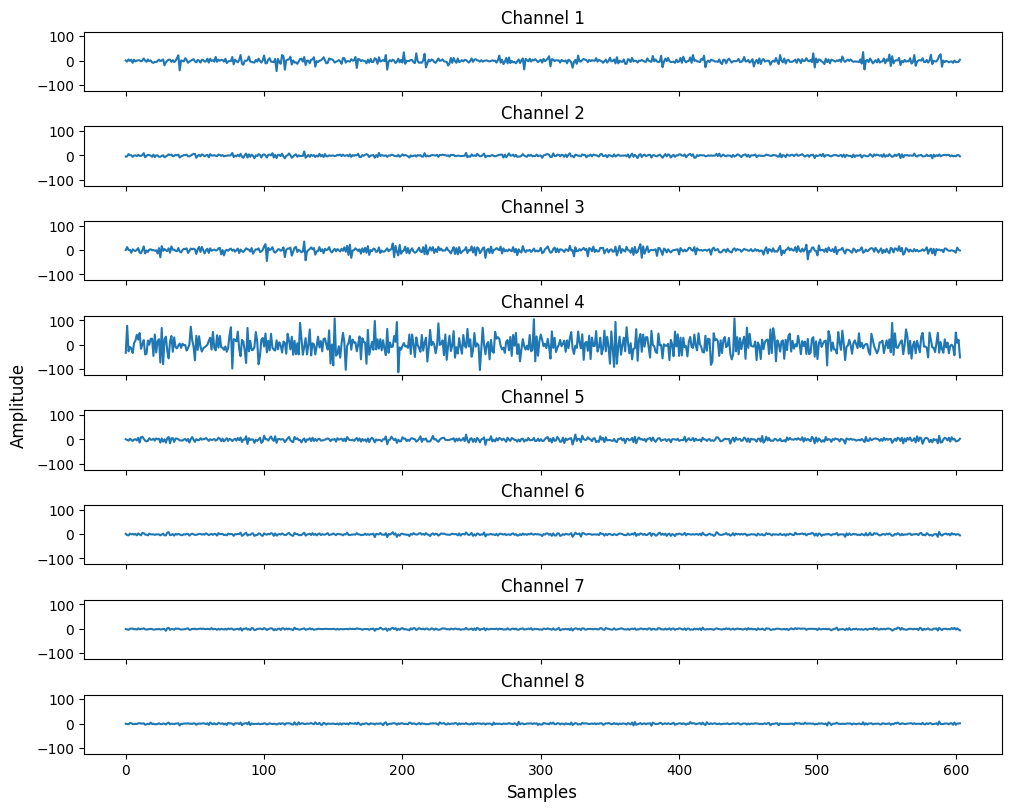

In [168]:
# Parse
odh = dataset.prepare_data()    # look inside this method to explore the parsing interface
print(f"Number of files: {len(odh.data)}")
print(f"EMG data shape (samples x channels): {odh.data[0].shape}")
plot_channels(odh.data[0])

In [21]:
print(f"Single rep metadata: {odh.reps[0][:50].ravel()}")   # each type of metadata is stored as a (samples x M) array (M depends on the metadata)

Single rep metadata: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [22]:
print(f"Sets metadata: {[set[0, 0] for set in odh.sets]}")
print(f"Reps metadata: {[rep[0, 0] for rep in odh.reps]}")

Sets metadata: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Reps metadata: [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0]


In [49]:
# Split based on metadata
train_odh = odh.isolate_data('sets', [0, 1])
test_odh = odh.isolate_data('sets', [3])
print(f"Number of training files: {len(train_odh.data)}")
print(f"Number of test files: {len(test_odh.data)}")

Number of training files: 20
Number of test files: 10


In [51]:
# You can also add OfflineDataHandler instances together
train_test_odh = train_odh + test_odh
print(f"Number of training files: {len(train_test_odh.data)}")

Number of training files: 30


EMG data shape (samples x channels): (604, 3)


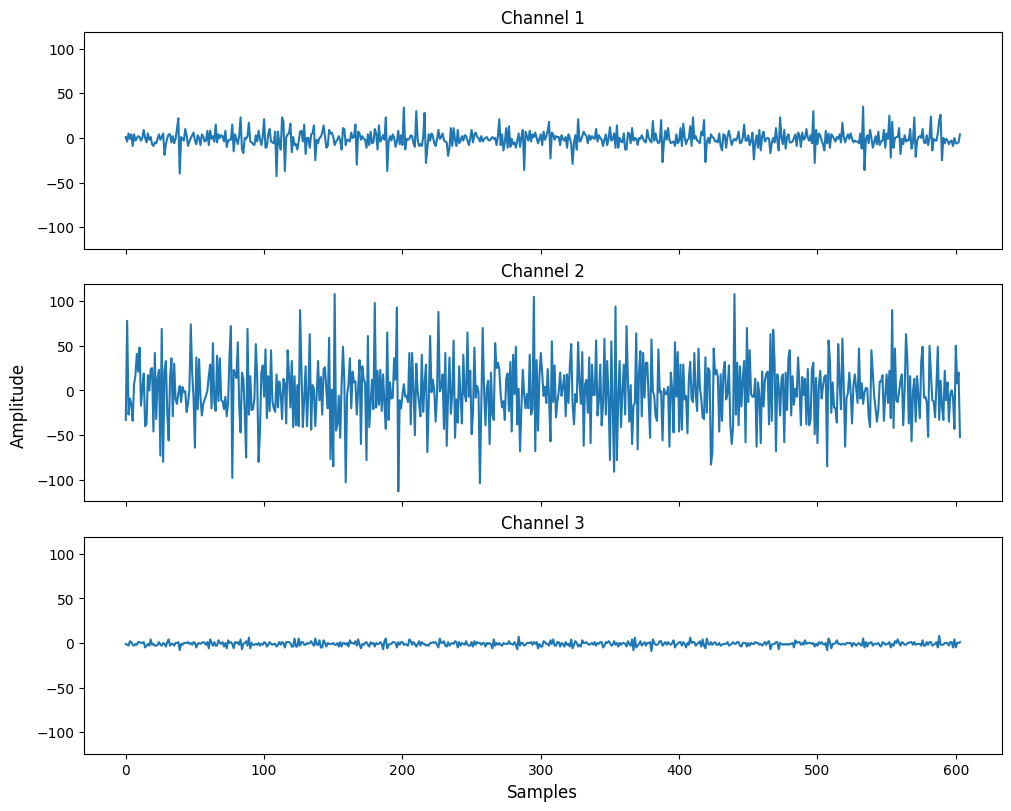

In [169]:
# Isolating by channels
channels_odh = odh.isolate_channels([0, 3, 7])
print(f"EMG data shape (samples x channels): {channels_odh.data[0].shape}")
plot_channels(channels_odh.data[0])

In [58]:
# Windowing
windows, metadata = odh.parse_windows(WINDOW_SIZE, WINDOW_INCREMENT)    # metadata grabbed based on mode by default, but can be customized with metadata_operations parameter
labels = metadata['classes']
print(f"Windows shape (windows x channels x samples): {windows.shape}")
print(f"Metadata shape (windows): {metadata['sets'].shape}")    # metadata value for each window
print(f"Example classes (windows): {metadata['classes'][:30]}")

Windows shape (windows x channels x samples): (539, 8, 200)
Metadata shape (windows): (539,)
Example classes (windows): [1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 2 2 2]


## Filtering

Filtering is a key component in a myoelectric control preprocessing pipeline due to the stochastic, noisy nature of EMG. `LibEMG` provides an interface to apply a variety of filters and offers convenience methods for commonly-used filters through the `Filter` class.

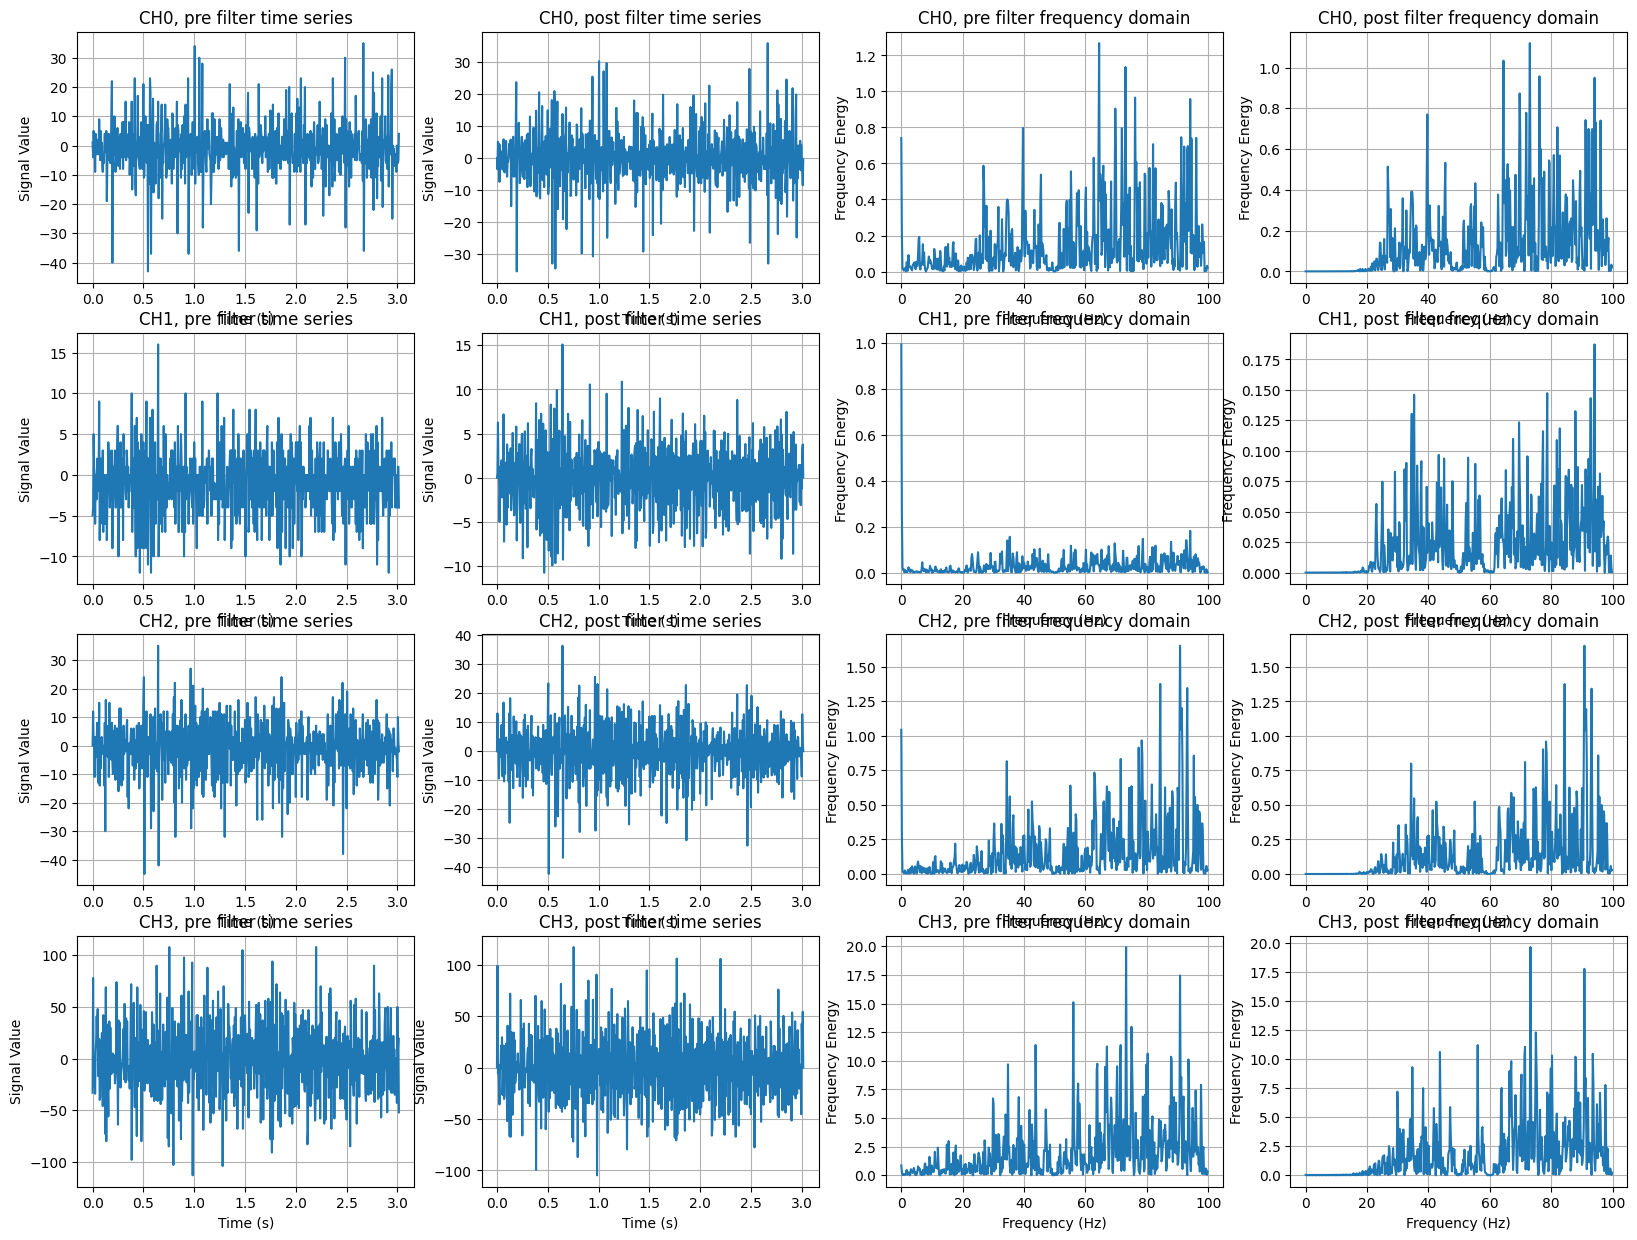

In [117]:
from libemg.filtering import Filter

filter = Filter(FS)
filter_configs = [
    {'name': 'notch', 'cutoff': 60, 'bandwidth': 3},
    {'name': 'highpass', 'cutoff': 20, 'order': 4}
]
for filter_config in filter_configs:
    filter.install_filters(filter_config)

filter.visualize_effect(odh.data[0][:, :4]) # lets us see the effect of filtering - we can see the removal of DC bias at 0 Hz

In [118]:
# Since the previous example is very common, LibEMG provides these filters in a convenience method
odh = dataset.prepare_data()
filter = Filter(FS)
filter.install_common_filters()
filter.filter(odh)  # modify odh.data field internally

60 data files fetched out of 61 files.
sampling frequency is inadaquate for the set of common filters.


## Feature Extraction

After EMG data have been preprocessed, we often extract features that are later used for classification or regression. `LibEMG` contains 50 different feature extraction methods that can be leveraged by passing in the corresponding string. This section explores the `FeatureExtractor` and its use cases.

In [174]:
from libemg.feature_extractor import FeatureExtractor

fe = FeatureExtractor()
print(f"Number of feature extraction methods: {len(fe.get_feature_list())}")    # prints the accepted parameters for feature extraction
print(fe.get_feature_groups())  # we also offer passing in a 'feature group'

Number of feature extraction methods: 50
{'HTD': ['MAV', 'ZC', 'SSC', 'WL'], 'TSTD': ['MAVFD', 'DASDV', 'WAMP', 'ZC', 'MFL', 'SAMPEN', 'M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'], 'DFTR': ['DFTR'], 'ITD': ['ISD', 'COR', 'MDIFF', 'MLK'], 'HJORTH': ['ACT', 'MOB', 'COMP'], 'LS4': ['LS', 'MFL', 'MSR', 'WAMP'], 'LS9': ['LS', 'MFL', 'MSR', 'WAMP', 'ZC', 'RMS', 'IAV', 'DASDV', 'VAR'], 'TDPSD': ['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'], 'TDAR': ['MAV', 'ZC', 'SSC', 'WL', 'AR'], 'COMB': ['WL', 'SSC', 'LD', 'AR9'], 'MSWT': ['WENG', 'WV', 'WWL', 'WENT']}


In [189]:
# Features are returned as a dictionary by default
feature_dict = fe.extract_features(['MAV', 'ZC', 'SSC', 'WL'], windows)
print(feature_dict.keys())

# We can also pass in the name of a feature group
features = fe.extract_feature_group('HTD', windows, array=True) # set array=True to return a matrix
print(f"Feature matrix (windows x features): {features.shape}")

dict_keys(['MAV', 'ZC', 'SSC', 'WL'])
Feature matrix (windows x features): (539, 32)


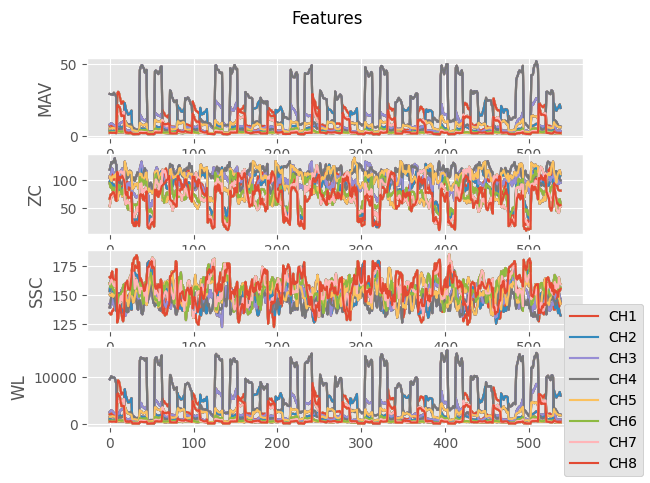

In [190]:
# Convenience methods to visualize features
fe.visualize(feature_dict)

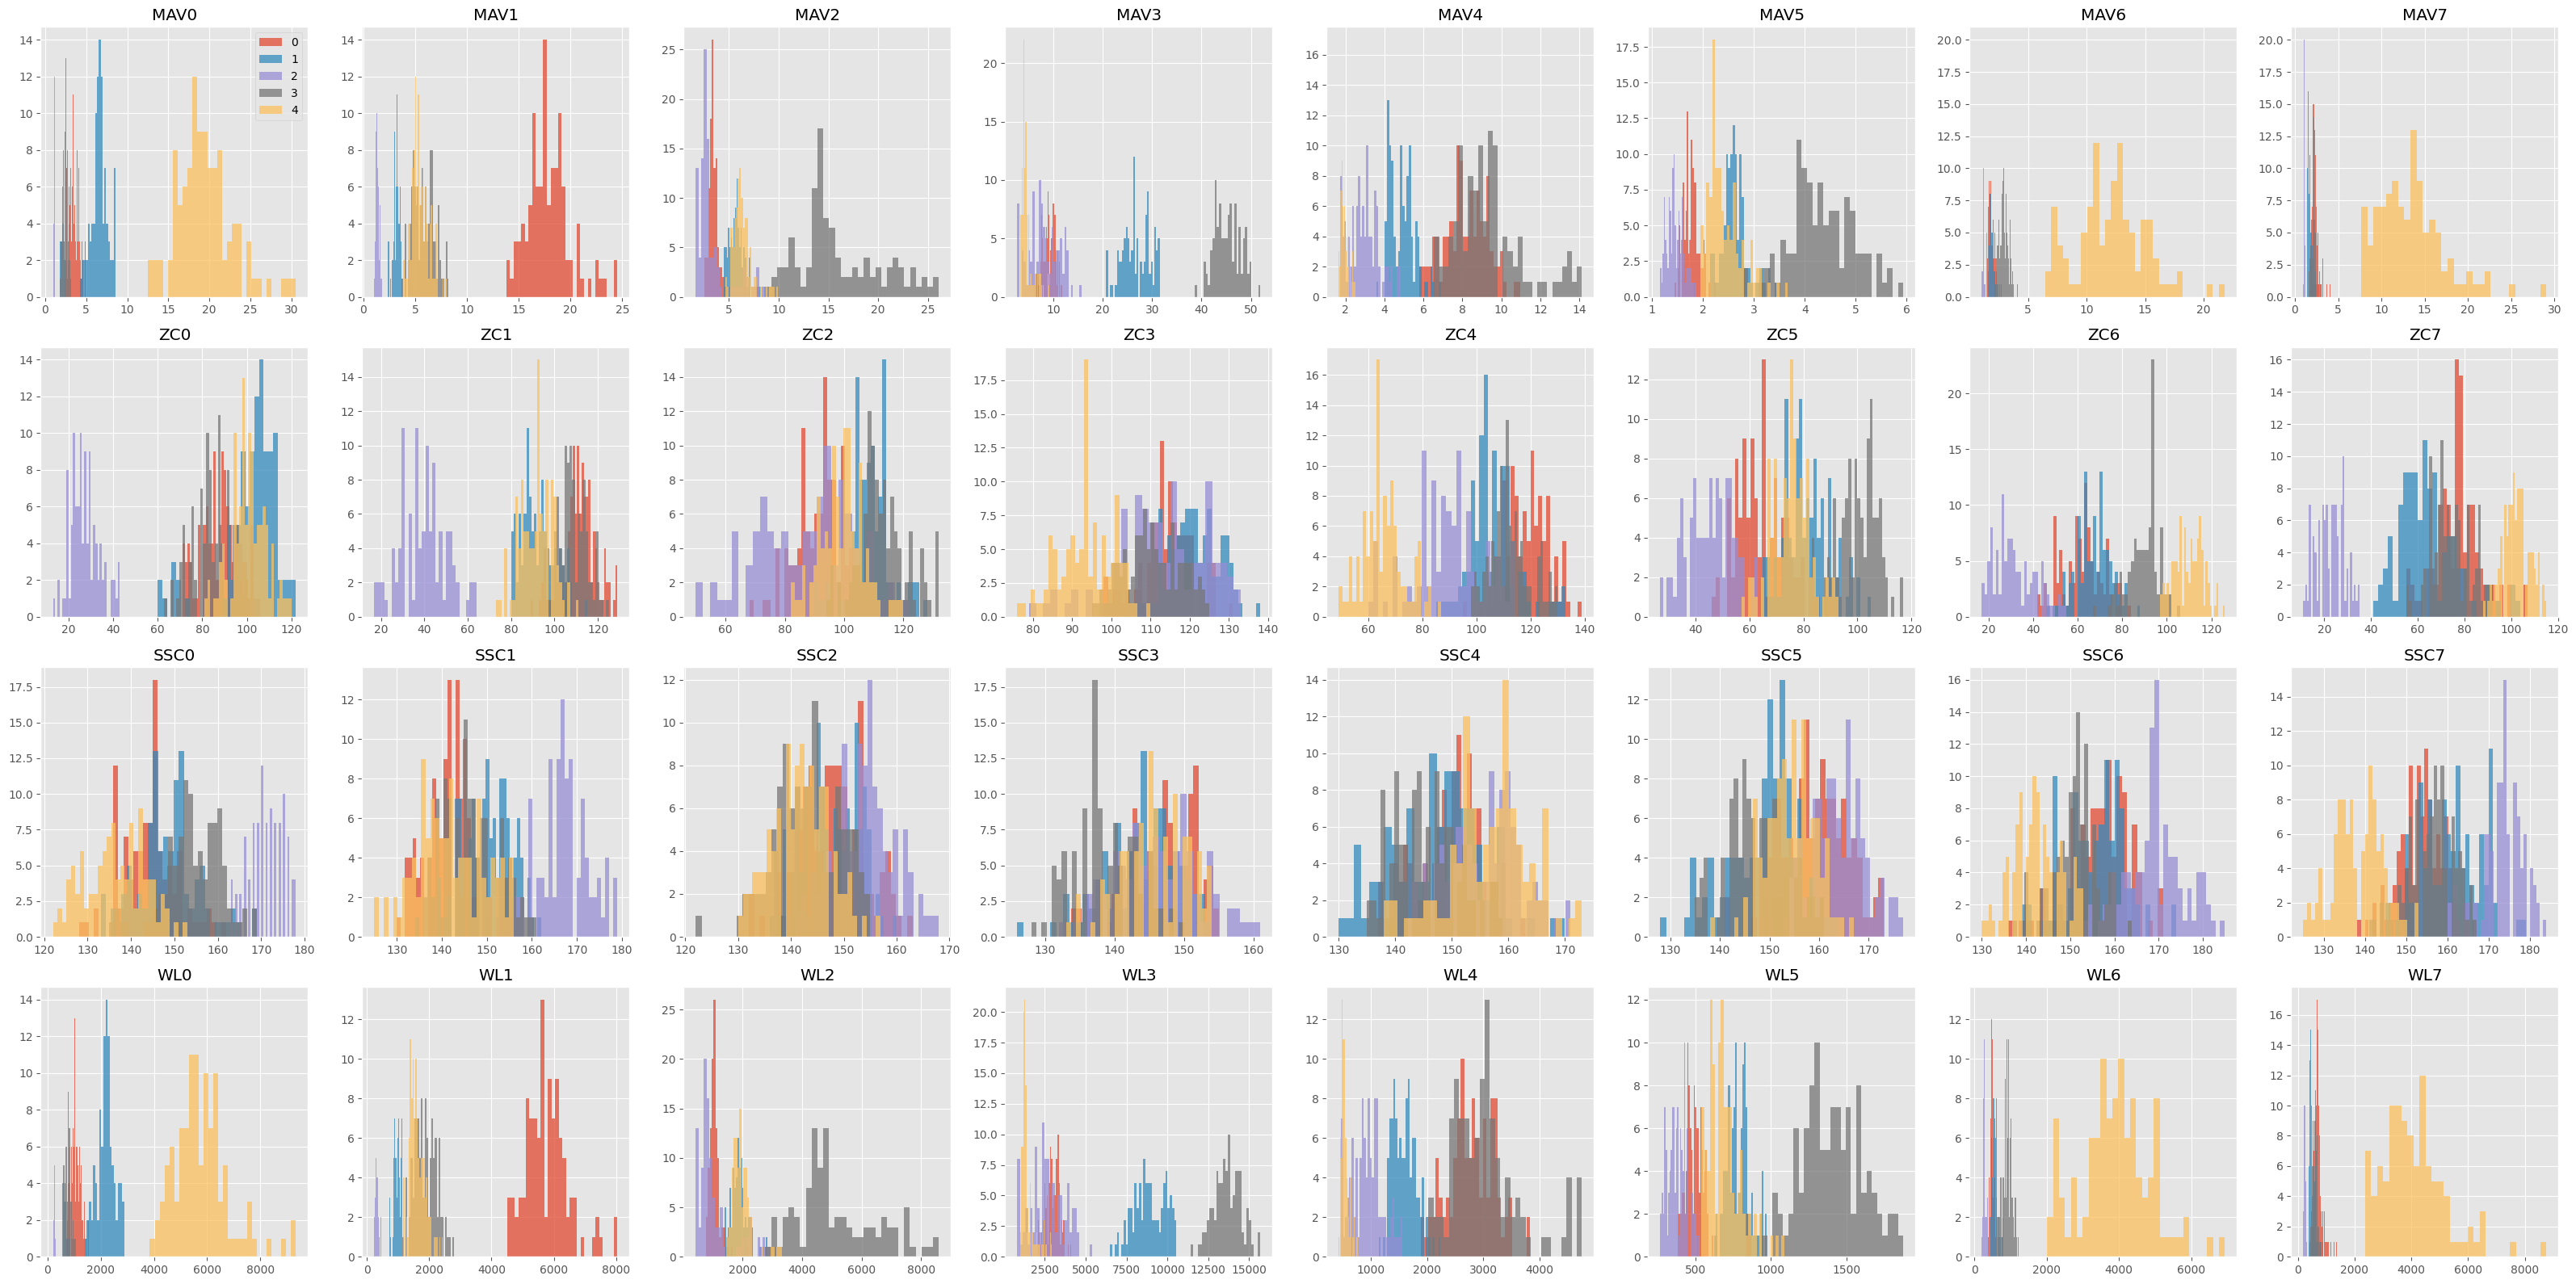

In [187]:
fe.visualize_all_distributions(feature_dict, classes=labels)

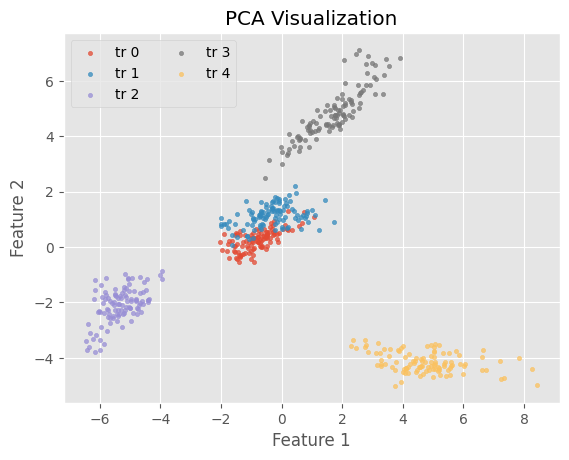

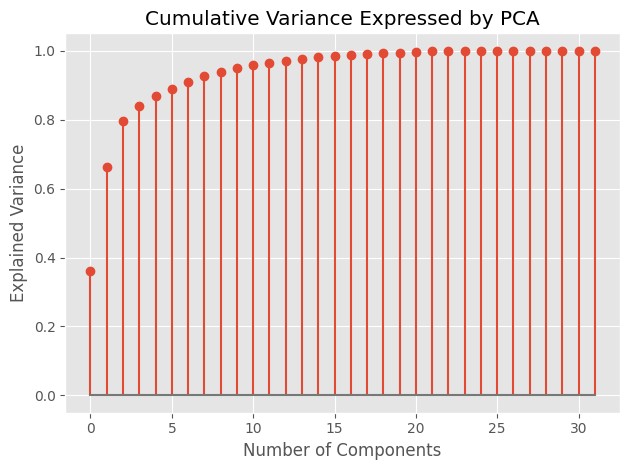

In [188]:
fe.visualize_feature_space(feature_dict, 'PCA', classes=labels)

## Classification

## Regression

## Offline Metrics